In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import os
import sys
from pathlib import Path
import kagglehub

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion()   # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')


In [2]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name())
else:
    print("⚠️ GPU is NOT active! Go to Runtime → Change runtime type → GPU")


CUDA available: True
GPU name: Tesla T4


In [3]:
# 1. Діагностика середовища (не обов'язково, але корисно)
if 'google.colab' in sys.modules:
    print("➡️ Running in Colab")
else:
    print("➡️ Running in local Python / VS Code")

# 2. Завантажуємо датасет через kagglehub
ds_path = kagglehub.dataset_download("puneet6060/intel-image-classification")
ds_path = Path(ds_path)   # робимо з цього Path-об'єкт

print("Dataset root:", ds_path)

# 3. Далі формуємо шляхи ВІД ds_path
# Подивись структуру, щоб переконатися, де там train/test/val
print("Contents of dataset root:", list(ds_path.iterdir()))

# Наприклад, якщо всередині щось типу 'seg_train', 'seg_test', 'seg_pred':
train_dir = ds_path / "seg_train" / "seg_train"
val_dir   = ds_path / "seg_test" / "seg_test"   # або seg_valid, залежить від датасету

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Train exists:", train_dir.exists())
print("Val exists:", val_dir.exists())

➡️ Running in Colab
Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset root: /kaggle/input/intel-image-classification
Contents of dataset root: [PosixPath('/kaggle/input/intel-image-classification/seg_train'), PosixPath('/kaggle/input/intel-image-classification/seg_pred'), PosixPath('/kaggle/input/intel-image-classification/seg_test')]
Train dir: /kaggle/input/intel-image-classification/seg_train/seg_train
Val dir: /kaggle/input/intel-image-classification/seg_test/seg_test
Train exists: True
Val exists: True


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
data_dir = ds_path
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val':   datasets.ImageFolder(val_dir,   data_transforms['val']),
}

In [6]:
dataloaders = {
    phase: torch.utils.data.DataLoader(
        image_datasets[phase],
        batch_size=32,
        shuffle=True if phase == 'train' else False,
        num_workers=4
    )
    for phase in ['train', 'val']
}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
class_names   = image_datasets['train'].classes

In [7]:
def show_batch(inputs, classes, class_names, n=8):
    # беремо перші n зображень
    inputs = inputs[:n]
    classes = classes[:n]

    # розкладемо, наприклад, у 2 рядки по 4
    n_rows = 2
    n_cols = (n + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
    axes = axes.flatten()

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for ax, img, label in zip(axes, inputs, classes):
        img = img.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(class_names[int(label)])
        ax.axis("off")

    # якщо картинок менше ніж осей — ховаємо зайві
    for ax in axes[len(inputs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

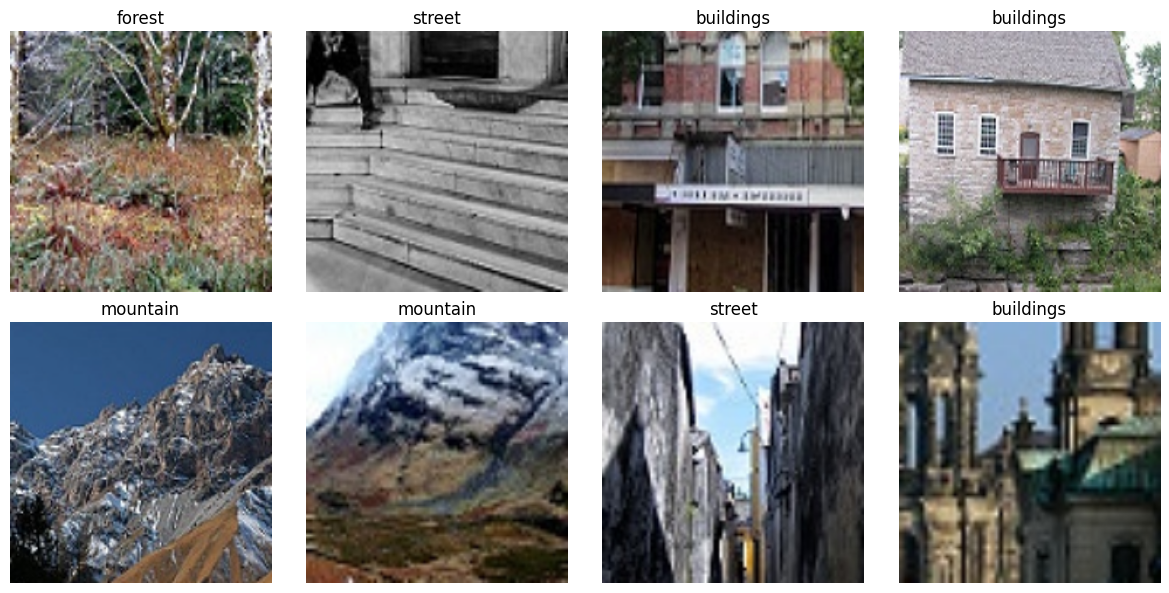

In [8]:
inputs, classes = next(iter(dataloaders['train']))
show_batch(inputs, classes, class_names, n=8)

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


{'train': 14034, 'val': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Using device: cuda:0


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
				
				# save model 
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


### Manual mode

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()

        # "Згорткова" частина (витягуємо ознаки)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
        )

        # "Класична" (fully connected) частина: робимо класифікацію
        self.classifier = nn.Sequential(
            nn.Linear(64 * 112 * 112, 128),  # flatten → перший шар
            nn.ReLU(),
            nn.Linear(128, num_classes)    # вихідний шар: по одному логіту на клас
        )

    def forward(self, x):
        x = self.features(x)              # згортки + pooling
        x = torch.flatten(x, 1)          # перетворили в (batch_size, N)
        x = self.classifier(x)           # повнозв'язні шари
        return x
        

In [19]:
num_classes = 6 

model = SimpleCNN(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# scheduler можна хоч зараз, хоч пізніше підключити
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.4404 Acc: 0.5025
val Loss: 0.9546 Acc: 0.6320

Epoch 2/15
----------
train Loss: 0.9731 Acc: 0.6342
val Loss: 0.7351 Acc: 0.7353

Epoch 3/15
----------
train Loss: 0.8647 Acc: 0.6794
val Loss: 0.6839 Acc: 0.7537

Epoch 4/15
----------
train Loss: 0.7940 Acc: 0.7041
val Loss: 0.5880 Acc: 0.7813

Epoch 5/15
----------
train Loss: 0.7498 Acc: 0.7210
val Loss: 0.5579 Acc: 0.7913

Epoch 6/15
----------
train Loss: 0.7313 Acc: 0.7277
val Loss: 0.5266 Acc: 0.8073

Epoch 7/15
----------
train Loss: 0.6928 Acc: 0.7371
val Loss: 0.5481 Acc: 0.7957

Epoch 8/15
----------
train Loss: 0.6743 Acc: 0.7464
val Loss: 0.5132 Acc: 0.8160

Epoch 9/15
----------
train Loss: 0.6813 Acc: 0.7475
val Loss: 0.5199 Acc: 0.8140

Epoch 10/15
----------
train Loss: 0.6453 Acc: 0.7598
val Loss: 0.4783 Acc: 0.8300

Epoch 11/15
----------
train Loss: 0.6383 Acc: 0.7626
val Loss: 0.5283 Acc: 0.8120

Epoch 12/15
----------
train Loss: 0.6258 Acc: 0.7640
val Loss: 0.5128 Acc: 0.8127

E

### Transfer Learning

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)  # змінюємо останній шар під нашу кількість класів
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)

model_ft = train_model(model_ft, 
                    criterion, 
                    optimizer_ft,
                    scheduler=None,  
                    num_epochs=15
            )



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s] 


Epoch 1/15
----------
train Loss: 0.6647 Acc: 0.7787
val Loss: 0.2627 Acc: 0.9133

Epoch 2/15
----------
train Loss: 0.3687 Acc: 0.8754
val Loss: 0.2165 Acc: 0.9243

Epoch 3/15
----------
train Loss: 0.3325 Acc: 0.8817
val Loss: 0.2056 Acc: 0.9227

Epoch 4/15
----------
train Loss: 0.3085 Acc: 0.8911
val Loss: 0.1914 Acc: 0.9310

Epoch 5/15
----------
train Loss: 0.2876 Acc: 0.8994
val Loss: 0.1846 Acc: 0.9343

Epoch 6/15
----------
train Loss: 0.2785 Acc: 0.9020
val Loss: 0.1793 Acc: 0.9330

Epoch 7/15
----------
train Loss: 0.2666 Acc: 0.9052
val Loss: 0.1719 Acc: 0.9370

Epoch 8/15
----------
train Loss: 0.2664 Acc: 0.9047
val Loss: 0.1732 Acc: 0.9400

Epoch 9/15
----------
train Loss: 0.2564 Acc: 0.9061
val Loss: 0.1701 Acc: 0.9393

Epoch 10/15
----------
train Loss: 0.2437 Acc: 0.9114
val Loss: 0.1648 Acc: 0.9347

Epoch 11/15
----------
train Loss: 0.2306 Acc: 0.9172
val Loss: 0.1640 Acc: 0.9373

Epoch 12/15
----------
train Loss: 0.2276 Acc: 0.9164
val Loss: 0.1645 Acc: 0.9387

E

In [14]:
# 1. Завантажуємо модель
model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# 2. Заморожуємо всі параметри (feature extractor)
for param in model_conv.parameters():
    param.requires_grad = False

# 3. Дістаємо кількість вхідних фіч у останнього Linear
num_ftrs = model_conv.classifier[1].in_features

# 4. Замінюємо останній Linear на наш (2 класи)
model_conv.classifier[1] = nn.Linear(num_ftrs, 6)

# 5. На девайс, лосс, оптимізатор
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier[1].parameters(), lr=0.001)

# 6. Тренування
model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    scheduler=None,
    num_epochs=15
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]


Epoch 1/15
----------
train Loss: 0.6795 Acc: 0.7767
val Loss: 0.3558 Acc: 0.8827

Epoch 2/15
----------
train Loss: 0.5035 Acc: 0.8184
val Loss: 0.3145 Acc: 0.8913

Epoch 3/15
----------
train Loss: 0.4869 Acc: 0.8234
val Loss: 0.2980 Acc: 0.8967

Epoch 4/15
----------
val Loss: 0.2892 Acc: 0.9000

Epoch 9/15
----------
train Loss: 0.4522 Acc: 0.8318
val Loss: 0.2740 Acc: 0.9050

Epoch 10/15
----------
train Loss: 0.4650 Acc: 0.8269
val Loss: 0.2785 Acc: 0.9050

Epoch 11/15
----------
train Loss: 0.4735 Acc: 0.8254
val Loss: 0.2844 Acc: 0.8967

Epoch 12/15
----------
train Loss: 0.4628 Acc: 0.8304
val Loss: 0.2845 Acc: 0.8990

Epoch 13/15
----------
train Loss: 0.4679 Acc: 0.8299
val Loss: 0.2754 Acc: 0.9077

Epoch 14/15
----------
train Loss: 0.4560 Acc: 0.8277
val Loss: 0.2774 Acc: 0.9010

Epoch 15/15
----------
train Loss: 0.4597 Acc: 0.8302
val Loss: 0.2805 Acc: 0.9000

Training complete in 11m 21s
Best val Acc: 0.907667


Що модна сказати. По-перше. дуже круто, що з'явилася можливість підключати Google Сolab у VS Code. Писати код на CPU, а тестити - підключати Colab. Подобається використовувати VS Code і мати GPU від Google.
Взагалі для мене це склдана, але цікава тема. Одного тижня не те що на вичення на ознайомлення мало. 
Тому я використовував код з конспекта. Теорія мені зрохцміла більш менш, а ось з кодом не все просто. Тестувати ріхні параметри модн адо безкінечності. Змінити один парметр, а потім чекати 20 хвилин - це щось). 

**Проста згорткова мережа:**
1 варіант - Best val Acc: 0.818667
2 варіант - Best val Acc: 0.697667
3 варіант - Best val Acc: 0.848333

**Transfer Learning. Повне навчання** - Best val Acc: 0.94

**Transfer Learning. Класифікаційний шар** - Best val Acc: 0.907667